In [2]:
import h5py, numpy as np, matplotlib.pyplot as plt, torch, torch.nn as nn, onnx
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [3]:
dim = 32
pred_steps = 5
with h5py.File("life_32_50k.h5", "r") as f:
    # use slicing to pull the entire dataset into memory immediately
    X = f["X"][:]
    y = f["Y"][:]
print(X.shape, y.shape)

(50000, 32, 32) (50000, 32, 32)


In [4]:
pos = X.mean()    # fraction of alive cells
neg = 1 - pos

print(neg/pos)

1.0034643498584055


In [5]:
class Life_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        m = 24
        self.net = nn.Sequential(
            nn.Conv2d(1, 2*m, kernel_size=3, padding=1), nn.BatchNorm2d(2*m), nn.ReLU(),
            nn.Conv2d(2*m,    m, kernel_size=1),         nn.BatchNorm2d(m),    nn.ReLU(),

            nn.Conv2d(m,   2*m, kernel_size=3, padding=1), nn.BatchNorm2d(2*m), nn.ReLU(),
            nn.Conv2d(2*m,    m, kernel_size=1),          nn.BatchNorm2d(m),    nn.ReLU(),

            nn.Conv2d(m,   2*m, kernel_size=3, padding=1), nn.BatchNorm2d(2*m), nn.ReLU(),
            nn.Conv2d(2*m,    m, kernel_size=1),          nn.BatchNorm2d(m),    nn.ReLU(),

            nn.Conv2d(m,   2*m, kernel_size=3, padding=1), nn.BatchNorm2d(2*m), nn.ReLU(),
            nn.Conv2d(2*m,    m, kernel_size=1),          nn.BatchNorm2d(m),    nn.ReLU(),

            nn.Conv2d(m,   2*m, kernel_size=3, padding=1), nn.BatchNorm2d(2*m), nn.ReLU(),
            nn.Conv2d(2*m,    m, kernel_size=1),          nn.BatchNorm2d(m),    nn.ReLU(),

            nn.Conv2d(m, 1, kernel_size=1)
        )

    def forward(self, x):
        return self.net(x)

In [15]:
# hyperparameters
learning_rate = 1e-3 # heuristic: double your batch size, you can safely increase the LR by up to √2
epochs = 100
batch_size = 64 # powers of 2

In [16]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1
)

X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_t   = torch.tensor(X_val,   dtype=torch.float32).unsqueeze(1)
y_val_t   = torch.tensor(y_val,   dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = Life_CNN().to(device)
pos = y_train.mean()    # fraction of alive cells
neg = 1 - pos
criterion = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor(neg/pos, device=device)
)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
# training loop
for epoch in range(1, epochs+1):
    model.train()
    running_loss = 0.0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch:03d}  avg loss = {running_loss/len(train_loader):.4f}")

Epoch 001  avg loss = 0.7627
Epoch 002  avg loss = 0.6883
Epoch 003  avg loss = 0.6397
Epoch 004  avg loss = 0.6129
Epoch 005  avg loss = 0.5975
Epoch 006  avg loss = 0.5874
Epoch 007  avg loss = 0.5746
Epoch 008  avg loss = 0.5628
Epoch 009  avg loss = 0.5546
Epoch 010  avg loss = 0.5451
Epoch 011  avg loss = 0.5432
Epoch 012  avg loss = 0.5357
Epoch 013  avg loss = 0.5310
Epoch 014  avg loss = 0.5267
Epoch 015  avg loss = 0.5219
Epoch 016  avg loss = 0.5208
Epoch 017  avg loss = 0.5338
Epoch 018  avg loss = 0.5136
Epoch 019  avg loss = 0.5065
Epoch 020  avg loss = 0.5068
Epoch 021  avg loss = 0.5109
Epoch 022  avg loss = 0.4886
Epoch 023  avg loss = 0.4826
Epoch 024  avg loss = 0.4743
Epoch 025  avg loss = 0.4578
Epoch 026  avg loss = 0.4395
Epoch 027  avg loss = 0.4185
Epoch 028  avg loss = 0.3926
Epoch 029  avg loss = 0.3650
Epoch 030  avg loss = 0.3091
Epoch 031  avg loss = 0.2424
Epoch 032  avg loss = 0.1935
Epoch 033  avg loss = 0.1577
Epoch 034  avg loss = 0.1388
Epoch 035  avg

In [18]:
def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_pixels = 0
    correct_pixels = 0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs  = imgs.to(device)
            masks = masks.to(device)

            logits = model(imgs)                   # (B,1,64,64)
            loss   = criterion(logits, masks)      # BCEWithLogitsLoss
            total_loss += loss.item() * imgs.size(0)

            probs = torch.sigmoid(logits)          # (B,1,64,64)
            preds = (probs > 0.5).float()          # binarize

            # pixel‐wise accuracy
            correct_pixels += (preds == masks).sum().item()
            total_pixels   += torch.numel(preds)

    avg_loss = total_loss / len(val_loader.dataset)
    pixel_acc = correct_pixels / total_pixels

    print(f"Validation — avg loss: {avg_loss:.4f}, pixel accuracy: {pixel_acc:.4%}")
    return avg_loss, pixel_acc


In [19]:
val_loss, val_acc = evaluate(model, val_loader, criterion, device)

Validation — avg loss: 0.0025, pixel accuracy: 99.9980%


In [20]:
def plot_predictions(model, loader, device, n_images=4):
    model.eval()
    # grab one batch
    imgs, masks = next(iter(loader))
    imgs, masks = imgs.to(device), masks.to(device)

    with torch.no_grad():
        logits = model(imgs)                # (B,1,64,64)
        probs  = torch.sigmoid(logits)
        preds  = (probs > 0.5).float()      # binarize

    imgs  = imgs.cpu()
    masks = masks.cpu()
    preds = preds.cpu()

    for i in range(min(n_images, imgs.size(0))):
        fig, axes = plt.subplots(1, 3, figsize=(9, 3))

        axes[0].imshow(imgs[i,0], cmap="binary", interpolation="nearest")
        axes[0].set_title("Input State")

        axes[1].imshow(masks[i,0], cmap="binary", interpolation="nearest")
        axes[1].set_title("True Next State")

        axes[2].imshow(preds[i,0], cmap="binary", interpolation="nearest")
        axes[2].set_title("Predicted Next State")

        for ax in axes:
            ax.axis("off")

        plt.tight_layout()
        plt.show()

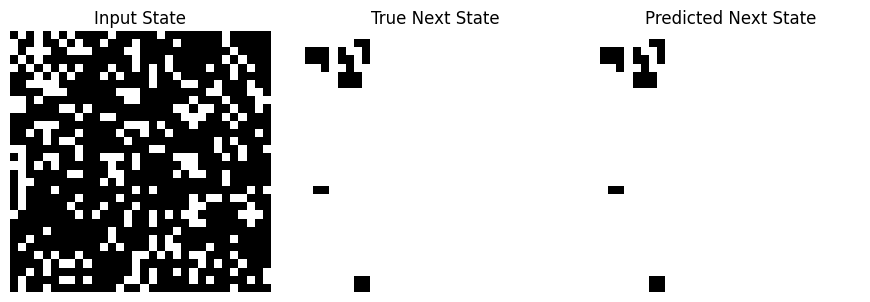

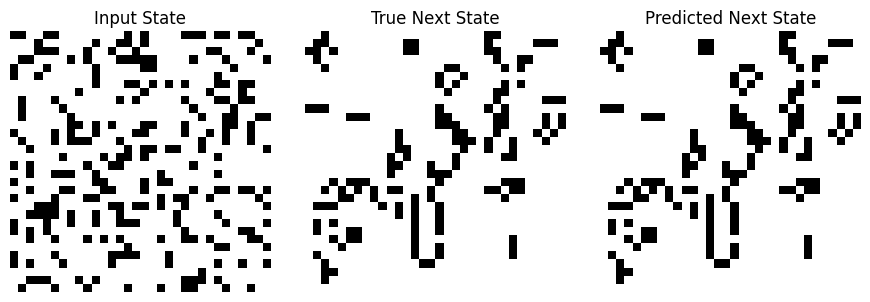

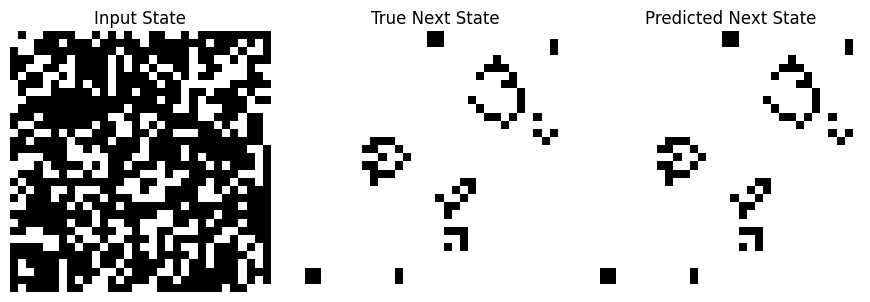

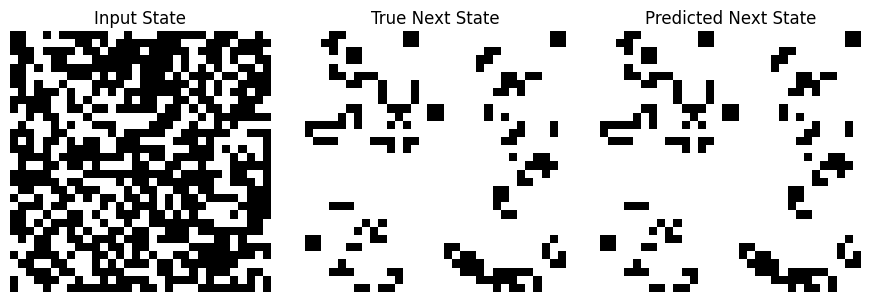

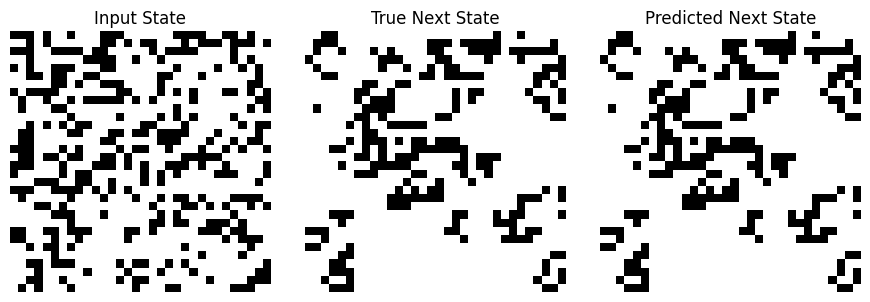

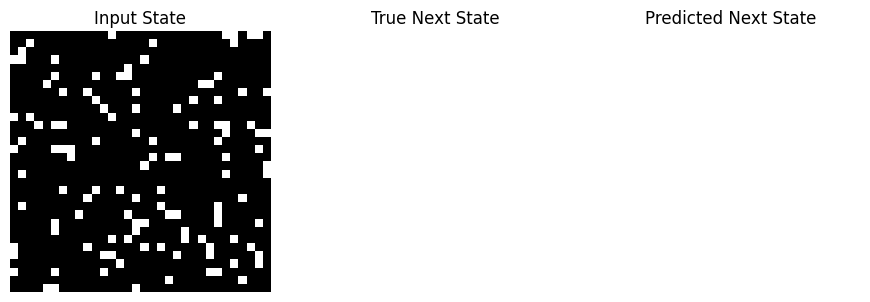

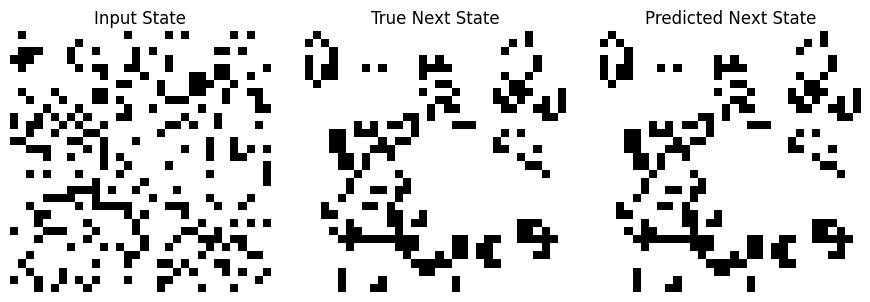

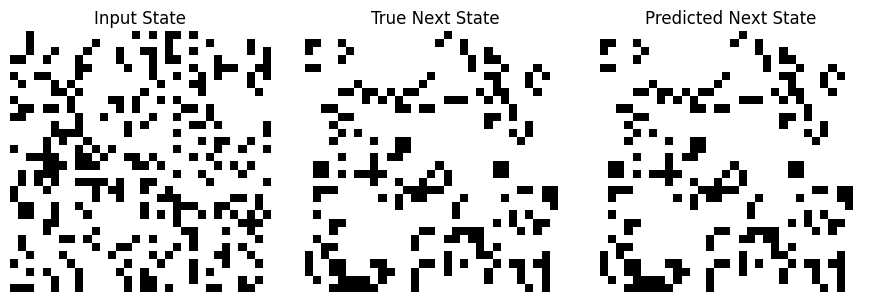

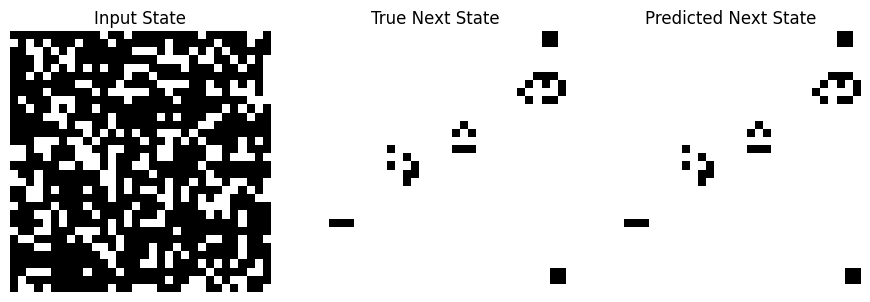

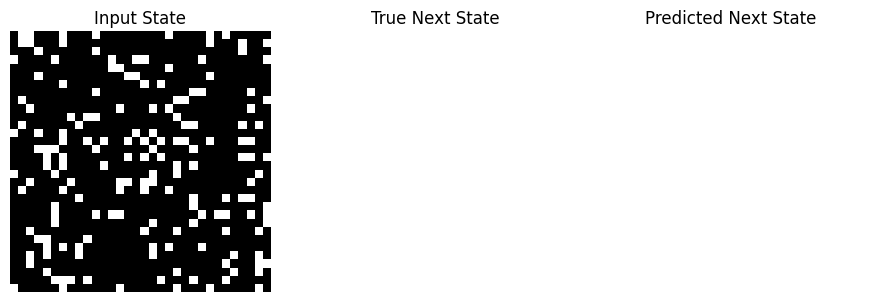

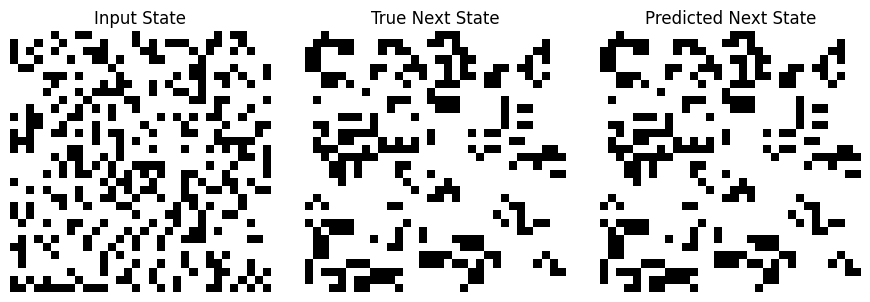

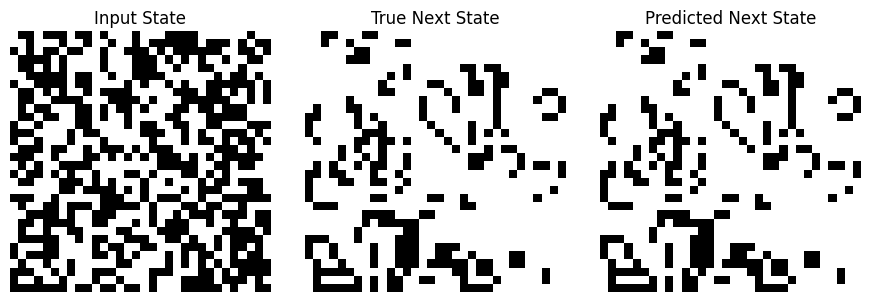

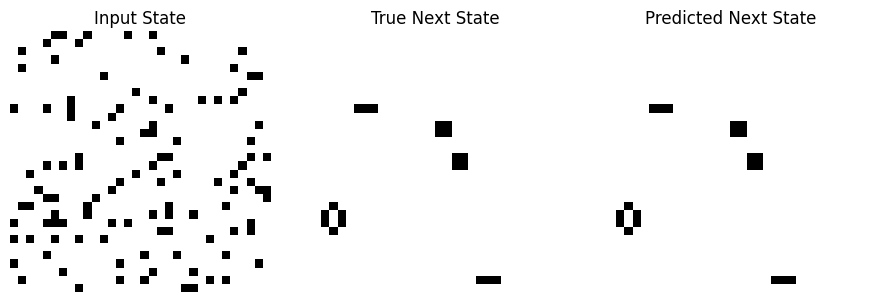

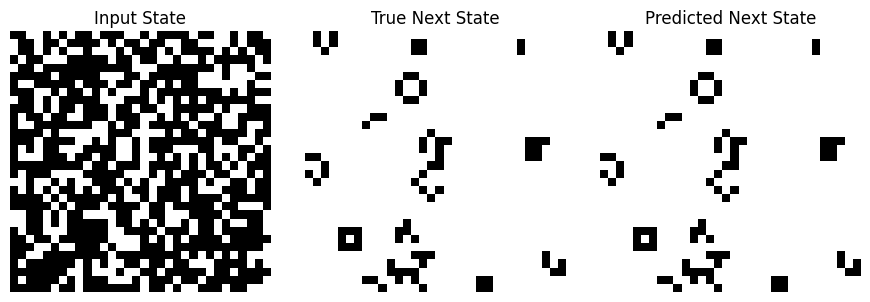

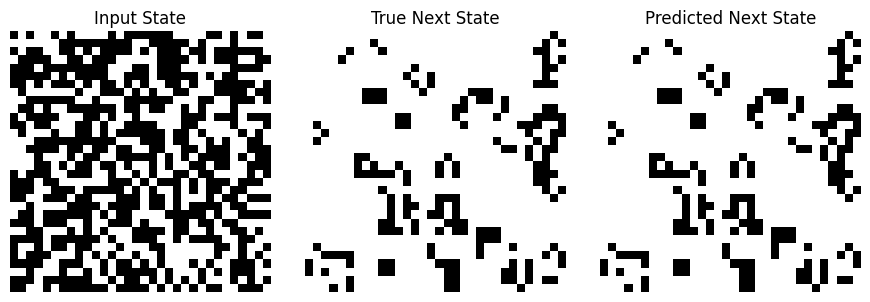

In [21]:
plot_predictions(model, val_loader, device, n_images=15)

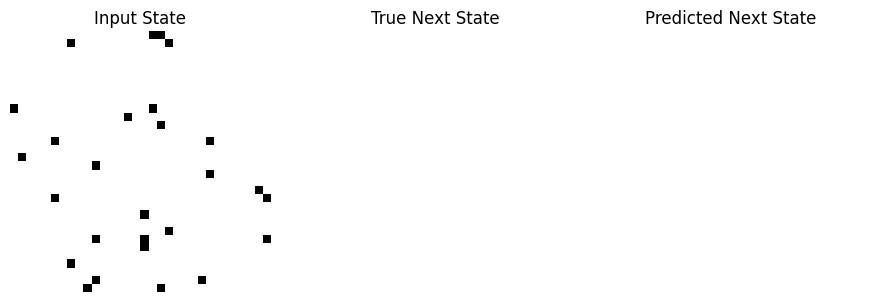

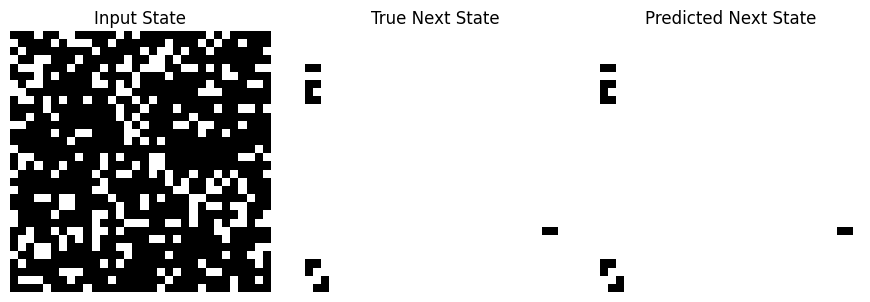

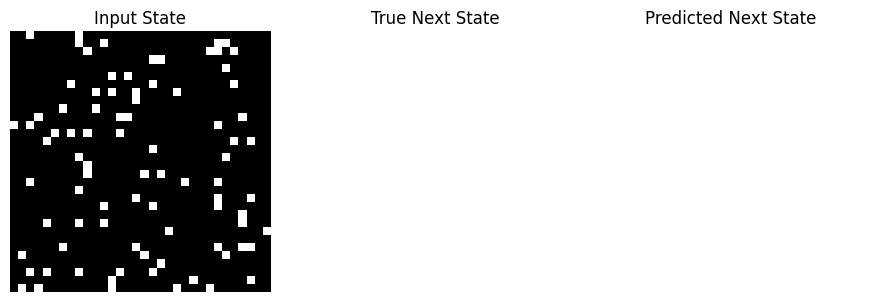

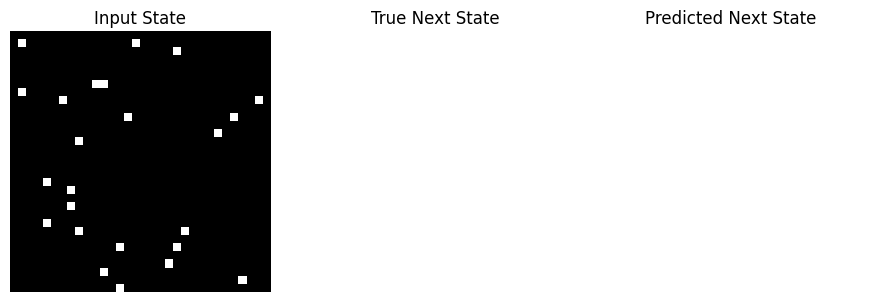

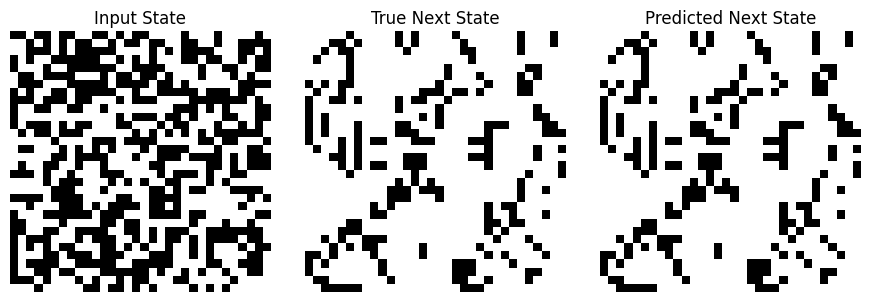

In [22]:
plot_predictions(model, train_loader, device, n_images=5)

In [ ]:
PATH = "model_weights.pt"
torch.save(model.state_dict(), PATH)

In [ ]:
model = Life_CNN().eval()
model.load_state_dict(torch.load("model_weights_2.pt", map_location="cpu"))
dummy = torch.randn(1,1,32,32)
torch.onnx.export(model, dummy, "life.onnx",
                  input_names=["x"], output_names=["y"],
                  dynamic_axes={"x":{0:"batch"}, "y":{0:"batch"}})